# Foraging - Joint Action Learning - Agent Modeling 

## Pre-Requisites

### Imports

In [1]:
import time
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from games.foraging import Foraging 
from agents.independent_q_learning import IQL
from agents.jal_am import JALAM

In [2]:
game = Foraging(config="Foraging-8x8-2p-2f-v3", seed=42)
game.reset()

#print game information
rewards = game.rewards
observations = game.observations
terminations = game.terminations
truncations = game.truncations
infos = game.infos
print("Game Information:")
print("Rewards: ", rewards)
print("Observations: ", observations)
print("Terminations: ", terminations)

print("Truncations: ", truncations)
print("Infos: ", infos)

Game Information:
Rewards:  {'agent_0': 0, 'agent_1': 0}
Observations:  {'agent_0': array([2., 1., 2., 5., 5., 2., 6., 5., 1., 3., 6., 1.], dtype=float32), 'agent_1': array([2., 1., 2., 5., 5., 2., 3., 6., 1., 6., 5., 1.], dtype=float32)}
Terminations:  {'agent_0': False, 'agent_1': False}
Truncations:  {'agent_0': False, 'agent_1': False}
Infos:  {'agent_0': {}, 'agent_1': {}}


c:\Users\marrt\miniconda3\envs\pettingzoo_games\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


### Epsilon and Alpha function that will be used in the Q-learning algorithm

Text(0.5, 1.0, 'Epsilon Function Decay')

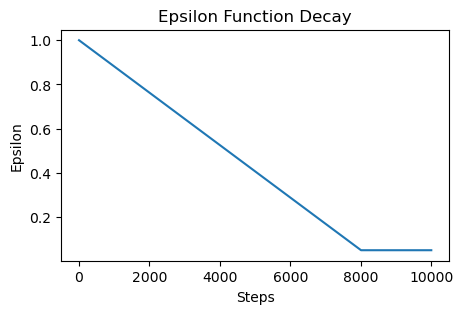

In [3]:
def epsilon_func(i: int, min_value=0.05, max_value=1.0, decay_steps=8000):
        """
        Epsilon decay should linearly decay from max_value to min_value in the first decay_steps,
        and then stay at min_value for the rest of the training.
        """
        if i < decay_steps:
            # Linearly decay epsilon
            return max_value - (max_value - min_value) * (i / decay_steps)
        else:
            # Keep epsilon at min_value after decay_steps
            return min_value
        
def get_epsilon_func(min_value=0.05, max_value=1.0, decay_steps=8000):
    """
    Returns the epsilon function with the specified parameters.
    """
    return partial(epsilon_func, min_value=min_value, max_value=max_value, decay_steps=decay_steps)

values = []
for i in range(0, 10000):
    epsilon = epsilon_func(i)
    values.append(epsilon)

plt.figure(figsize=(5, 3))
plt.plot(values)
plt.xlabel('Steps')
plt.ylabel('Epsilon')
plt.title('Epsilon Function Decay')

In [4]:
# Alpha is just 0.1 for all steps
def alpha_func(i: int, value=0.1):
        return 0.1

def get_alpha_func(value=0.1):
    """
    Returns the alpha function with the specified parameters.
    """
    return partial(alpha_func, value=value)

### Utility functions

In [5]:
def run(game, agents, verbose=False, render=False, training=True):
    game.reset()
    cum_rewards = dict(map(lambda agent: (agent, 0), game.agents))

    if render:
        game.render()
        time.sleep(2) # Wait for 2 seconds before starting the game

    while not game.done():
        actions = dict(map(lambda agent: (agent, agents[agent].action()), game.agents))
        game.step(actions)

        for agent in game.agents:
            if training:
                # Update the agent only if training is enabled
                agents[agent].update(actions)
            cum_rewards[agent] += game.reward(agent)

        if verbose:
            for agent in game.agents:
                    print(f"Agent {agent} reward: {game.reward(agent)}")
                    print(f"Agent {agent} observe: {game.observe(agent)}")
            
        if render:
            game.render()
            time.sleep(0.1)
        
    return cum_rewards

In [6]:
def train(game, agents, iterations, episodes_per_iteration, verbose=False):
    reward_list = {agent: [] for agent in game.agents}
    rewards_per_iteration = {agent: [] for agent in game.agents}
    for i in range(iterations):
        for j in range(episodes_per_iteration):
            cum_rewards = run(game, agents, verbose=False, render=False, training=True)
            for agent in game.agents:
                reward_list[agent].append(cum_rewards[agent])

        for agent in game.agents:
            rewards_per_iteration[agent].append(np.mean(reward_list[agent][-episodes_per_iteration:]))
        if verbose:
            # Print the average rewards for each agent after each iteration
            print(f"Iteration {i+1}, Total Episodes {(j+1)* (i+1)}")
            for agent in game.agents:
                print(f"Agent {agent}, Average reward: {rewards_per_iteration[agent][i]}")
    
    # return the average rewards for each agent after training
    return rewards_per_iteration

def plot_rewards(rewards, config):
    plt.figure(figsize=(10, 5))
    for agent in rewards:
        plt.plot(rewards[agent], label=f"Agent {agent}")
    plt.title(f"Rewards for Configuration {config['game']}")
    plt.xlabel("Iterations")
    plt.ylabel("Rewards")
    plt.legend()
    plt.grid()
    plt.show()

In [7]:
def plot_rewards_on_multiple_runs(all_rewards, config):
    # Convert to 3D array: runs x agents x iterations
    all_rewards = np.array(all_rewards)

    # Compute mean and std across runs, for each agent and iteration
    mean_rewards = np.mean(all_rewards, axis=0)  # shape: agents x iterations
    std_rewards = np.std(all_rewards, axis=0)    # shape: agents x iterations

    # Plot mean and std for each agent
    iterations = np.arange(mean_rewards.shape[1])
    for agent_idx, agent in enumerate(game.agents):
        plt.plot(iterations, mean_rewards[agent_idx], label=f"Agent {agent} Mean")
        plt.fill_between(iterations, 
                        mean_rewards[agent_idx] - std_rewards[agent_idx], 
                        mean_rewards[agent_idx] + std_rewards[agent_idx], 
                        alpha=0.2, label=f"Agent {agent} Std")

    plt.title(f"Mean and Std Rewards over {config['num_runs']} Runs for {config['game']}")
    plt.xlabel("Iterations")
    plt.ylabel("Rewards")
    plt.legend()
    plt.grid()
    plt.show()

def plot_sum_all_rewards(all_rewards, config):
    # all_rewards shape: (num_runs, num_agents, num_iterations)
    # Compute sum of rewards across agents for each run and iteration
    sum_rewards_per_run = np.sum(all_rewards, axis=1)  # shape: (num_runs, num_iterations)

    # Compute mean and std across runs, for each iteration
    mean_sum_rewards = np.mean(sum_rewards_per_run, axis=0)  # shape: (num_iterations,)
    std_sum_rewards = np.std(sum_rewards_per_run, axis=0)    # shape: (num_iterations,)

    # Plot mean and std of sum of rewards
    iterations = np.arange(mean_sum_rewards.shape[0])
    plt.plot(iterations, mean_sum_rewards, label="Mean Sum of Rewards")
    plt.fill_between(iterations, 
                    mean_sum_rewards - std_sum_rewards, 
                    mean_sum_rewards + std_sum_rewards, 
                    alpha=0.2, label="Std Dev")
    plt.axhline(y=1, color='r', linestyle='--', label="Target")
    plt.title(f"Mean and Std of Sum of Rewards over {config['num_runs']} Runs for {config['game']}")
    plt.xlabel("Iterations")
    plt.ylabel("Sum of Rewards")
    plt.legend()
    plt.grid()
    plt.show()

## 5x5 - 2 Players - 2 Food

<img src="./attachments/5x5-2p-2f.png" width="200"/>

In [8]:
config = {
        "game": "Foraging-5x5-2p-2f-v3",
        "seed": 3,
        "num_runs": 5,
        "agent": {
            "alpha": get_alpha_func(),
            "epsilon": get_epsilon_func(),
            "gamma": 0.9,
        },
        "train": {
            "iterations": 10,
            "episodes_per_iteration": 1000,
        },
    }

Run 1/5


c:\Users\marrt\miniconda3\envs\pettingzoo_games\Lib\site-packages\gymnasium\utils\passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


Run 2/5
Run 3/5
Run 4/5
Run 5/5


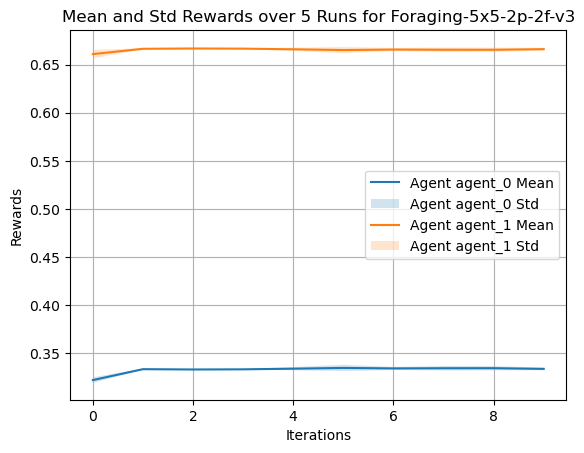

In [9]:
all_rewards = []

for i in range(config["num_runs"]):
    print(f"Run {i+1}/{config['num_runs']}")
    game = Foraging(config=config["game"], seed=config["seed"]) 
    agents = {agent: JALAM(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], 
                         gamma=config["agent"]["gamma"], seed=i)
                for agent in game.agents
            }
    rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=False)
    rewards_matrix = np.array([rewards[agent] for agent in game.agents])
    all_rewards.append(rewards_matrix)

plot_rewards_on_multiple_runs(all_rewards, config)


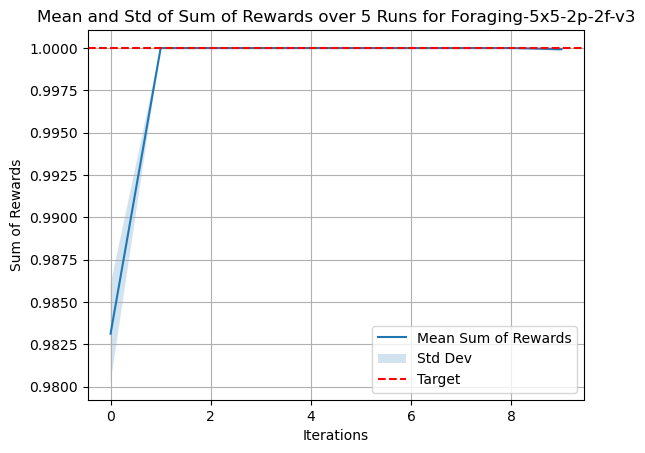

In [12]:
plot_sum_all_rewards(all_rewards, config)

In [ ]:
# Run a single episode on the last trained agents
#run(game, agents, verbose=False, render=True, training=False) # Uncomment to run a single episode

c:\Users\marrt\miniconda3\envs\pettingzoo_games\Lib\site-packages\pyglet\libs\win32\__init__.py:318: UserWarning: Could not set COM MTA mode. Unexpected behavior may occur.
  warnings.warn("Could not set COM MTA mode. Unexpected behavior may occur.")


{'agent_0': 0.3333333333333333, 'agent_1': 0.6666666666666666}

## 8x8 - 2 Players - 2 Food

<img src="./attachments/8x8-2p-2f.png" width="300"/>

In [14]:
config = {
        "game": "Foraging-8x8-2p-2f-v3",
        "seed": 3,
        "num_runs": 5,
        "agent": {
            "alpha": get_alpha_func(),
            "epsilon": get_epsilon_func(),
            "gamma": 0.9
        },
        "train": {
            "iterations": 10,
            "episodes_per_iteration": 1000,
        },
    }

Run 1/5


c:\Users\marrt\miniconda3\envs\pettingzoo_games\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\Users\marrt\miniconda3\envs\pettingzoo_games\Lib\site-packages\gymnasium\utils\passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


Run 2/5
Run 3/5
Run 4/5
Run 5/5


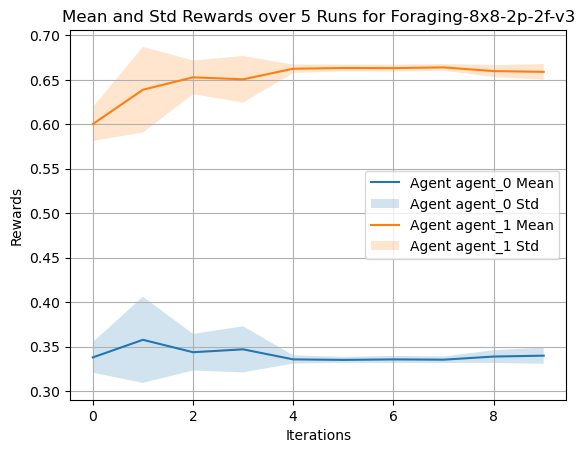

In [16]:
all_rewards = []

for i in range(config["num_runs"]):
    print(f"Run {i+1}/{config['num_runs']}")
    game = Foraging(config=config["game"], seed=config["seed"]) 
    agents = {agent: JALAM(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], 
                         gamma=config["agent"]["gamma"], seed=i)
                for agent in game.agents
            }
    rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=False)
    rewards_matrix = np.array([rewards[agent] for agent in game.agents])
    all_rewards.append(rewards_matrix)

plot_rewards_on_multiple_runs(all_rewards, config)

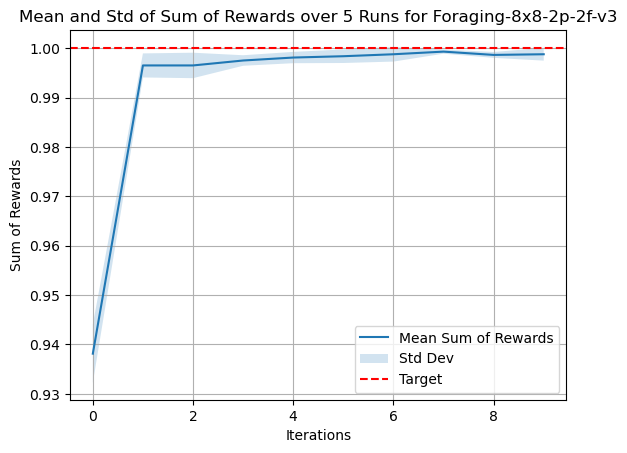

In [18]:
plot_sum_all_rewards(all_rewards, config)

In [ ]:
# Run the agents with render to see how they behave in the environment.
#run(game, agents, verbose=False, render=True, training=False) # Uncomment to run a single episode

{'agent_0': 0.3333333333333333, 'agent_1': 0.6666666666666666}

## 8x8 - 2 Players - 3 Food

<img src="./attachments/8x8-2p-3f.png" width="300"/>

In [30]:
config = {
        "game": "Foraging-8x8-2p-3f-v3",
        "seed": 3,
        "num_runs": 5,
        "agent": {
            "alpha": get_alpha_func(),
            "epsilon": get_epsilon_func(),
            "gamma": 0.9
        },
        "train": {
            "iterations": 10, # A difference with IQL is that we do not need more iterations
            "episodes_per_iteration": 1000,
        },
    }

Run 1/5
Run 2/5
Run 3/5
Run 4/5
Run 5/5


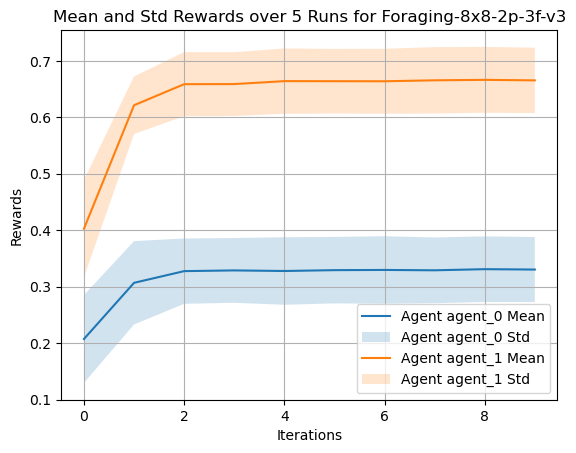

In [31]:
all_rewards = []

for i in range(config["num_runs"]):
    print(f"Run {i+1}/{config['num_runs']}")
    game = Foraging(config=config["game"], seed=config["seed"]) 
    agents = {agent: JALAM(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], 
                         gamma=config["agent"]["gamma"], seed=i)
                for agent in game.agents
            }
    rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=False)
    rewards_matrix = np.array([rewards[agent] for agent in game.agents])
    all_rewards.append(rewards_matrix)

plot_rewards_on_multiple_runs(all_rewards, config)

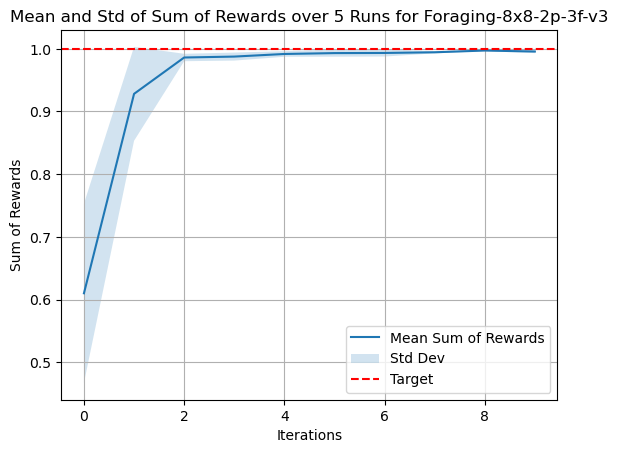

In [32]:
plot_sum_all_rewards(all_rewards, config)

In [ ]:
# Run the agents with render to see how they behave in the environment.
#run(game, agents, verbose=False, render=True, training=False) # Uncomment to run a single episode

{'agent_0': 0.2777777777777778, 'agent_1': 0.7222222222222221}

## 8x8 - 3 Players - 1 Food

Aumentamos la cantidad de agentes para ver como se comportan en un ambiente más complejo.

<img src="./attachments/8x8-3p-1f.png" width="300"/>

In [34]:
config = {
        "game": "Foraging-8x8-3p-1f-v3",
        "seed": 1,
        "num_runs": 5,
        "agent": {
            "alpha": get_alpha_func(),
            "epsilon": get_epsilon_func(),
            "gamma": 0.9,
        },
        "train": {
            "iterations": 10,
            "episodes_per_iteration": 1000,
        },
    }

Run 1/5
Run 2/5
Run 3/5
Run 4/5
Run 5/5


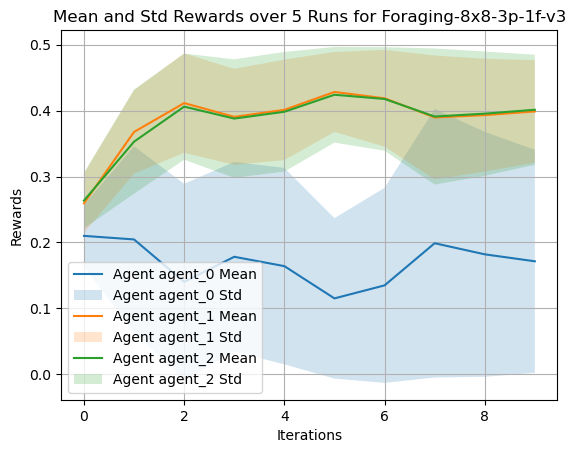

In [35]:
all_rewards = []

for i in range(config["num_runs"]):
    print(f"Run {i+1}/{config['num_runs']}")
    game = Foraging(config=config["game"], seed=config["seed"]) 
    agents = {agent: JALAM(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], 
                         gamma=config["agent"]["gamma"], seed=i)
                for agent in game.agents
            }
    rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=False)
    rewards_matrix = np.array([rewards[agent] for agent in game.agents])
    all_rewards.append(rewards_matrix)

plot_rewards_on_multiple_runs(all_rewards, config)

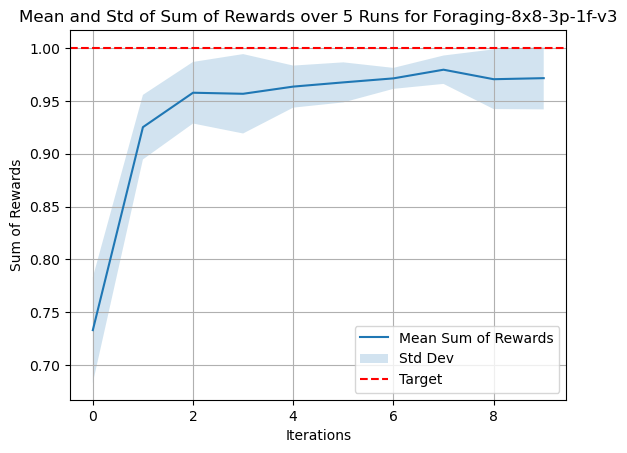

In [36]:
plot_sum_all_rewards(all_rewards, config)

In [37]:
# Run the agents with render to see how they behave in the environment.
run(game, agents, verbose=False, render=True, training=False) # Uncomment to run a single episode

{'agent_0': 0, 'agent_1': 0.5, 'agent_2': 0.5}

## Foraging: 8x8 - 3 Players - 2 Food

Esta configuración de ambiente necesita más tiempo de entrenamiento, por lo que aumentamos la cantidad de iteraciones a 100. Además actualizamos la taza de decay de la función epsilon para corresponder a la cantidad de iteraciones.

<img src="./attachments/8x8-3p-2f.png" width="300"/>

In [8]:
config = {
        "game": "Foraging-8x8-3p-2f-v3",	
        "seed": 3,
        "num_runs": 5,
        "agent": {
            "alpha": get_alpha_func(),
            "epsilon": get_epsilon_func(), # Cambiamos decay_steps de 8000 a 100000
            "gamma": 0.9,
        },
        "train": {
            "iterations": 50, # Utilizamos 400 iteraciones en lugar de 10.
            "episodes_per_iteration": 1000, 
        }, # Esto nos da un total de 400.000 episodios.
    }

Utilizamos concurrencia para hacer runs en paralelo y así acelerar el proceso de entrenamiento. Esto es bastante frágil y puede fallar pero nos ayuda mucho a reducir significativamente el tiempo de entrenamiento.

In [ ]:
from games.foraging import Foraging 
from agents.jal_am import JALAM
import concurrent.futures
from experiment_utils import plot_rewards_on_multiple_runs, plot_sum_all_rewards, get_alpha_func, get_epsilon_func, single_run

config = {
        "game": "Foraging-8x8-3p-2f-v3",	
        "seed": 3,
        "num_runs": 5,
        "agent": {
            "alpha": get_alpha_func(),    
            "epsilon": get_epsilon_func(),
            "gamma": 0.9,
        },
        "train": {
            "iterations": 30,
            "episodes_per_iteration": 1000, 
        }, 
    }

all_rewards = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    futures = []
    for i in range(config["num_runs"]):
        print(f"Launched run {i+1}/{config['num_runs']}")
        game = Foraging(config=config["game"], seed=config["seed"]) 
        agents = {agent: JALAM(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], 
                             gamma=config["agent"]["gamma"], seed=i)
                    for agent in game.agents
                }
        futures.append(executor.submit(single_run, game, i, config)) 
   
    for i, future in enumerate(concurrent.futures.as_completed(futures)):
        print(f"Finished run {i+1}/{config['num_runs']}")
        all_rewards.append(future.result())

plot_rewards_on_multiple_runs(all_rewards, config)

Launched run 1/5
Launched run 2/5
Launched run 3/5
Launched run 4/5
Launched run 5/5


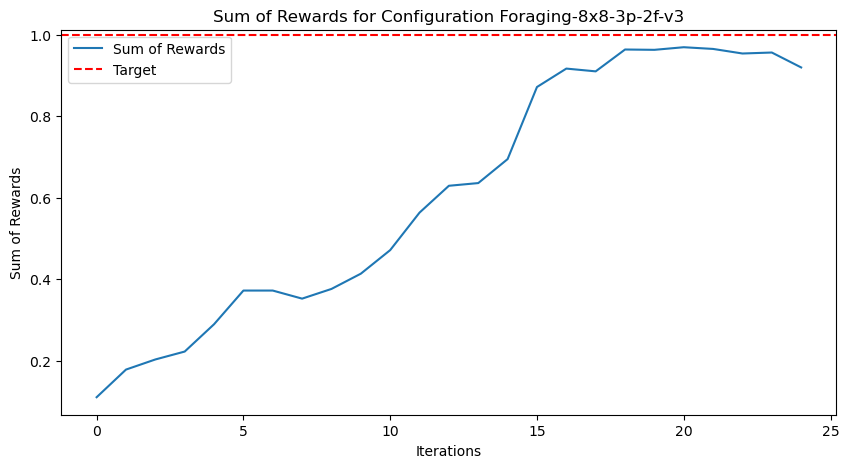

: 

In [ ]:
plot_sum_all_rewards(all_rewards, config)

In [ ]:
# Run the agents with render to see how they behave in the environment.
# run(game, agents, verbose=False, render=True, training=False) # Uncomment to run a single episode

Agent agent_0 reward: 0
Agent agent_0 observe: [1. 5. 3. 4. 3. 2. 1. 2. 1. 6. 5. 2. 1. 0. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 5. 3. 4. 3. 2. 6. 5. 2. 1. 2. 1. 1. 0. 1.]
Agent agent_2 reward: 0
Agent agent_2 observe: [1. 5. 3. 4. 3. 2. 1. 0. 1. 1. 2. 1. 6. 5. 2.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 5. 3. 4. 3. 2. 0. 2. 1. 6. 4. 2. 2. 0. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 5. 3. 4. 3. 2. 6. 4. 2. 0. 2. 1. 2. 0. 1.]
Agent agent_2 reward: 0
Agent agent_2 observe: [1. 5. 3. 4. 3. 2. 2. 0. 1. 0. 2. 1. 6. 4. 2.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 5. 3. 4. 3. 2. 1. 2. 1. 6. 3. 2. 2. 0. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 5. 3. 4. 3. 2. 6. 3. 2. 1. 2. 1. 2. 0. 1.]
Agent agent_2 reward: 0
Agent agent_2 observe: [1. 5. 3. 4. 3. 2. 2. 0. 1. 1. 2. 1. 6. 3. 2.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 5. 3. 4. 3. 2. 1. 3. 1. 6. 3. 2. 3. 0. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 5. 3. 4. 

{'agent_0': 0, 'agent_1': 0.4, 'agent_2': 0}